In [2]:
import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf

In [4]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [5]:
logging.info('abc')

08/04/2017 10:47:47 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:

import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=128
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(1*(y==0),dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(128,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [6]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [7]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [8]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [9]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [10]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [11]:
print np.mean(daily_data==0)

0.0909115851232


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [25]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        logits_sum=tf.identity(logits_sum,name="logits")
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                float_labels = tf.cast(y, tf.float32)
                predictions = tf.sigmoid(logits_sum, name='prediction')
                
                this_loss =  float_labels*tf.log(predictions+1e-8)+(1-float_labels)*tf.log(1-predictions+1e-8)
                print "this loss", this_loss.get_shape(),predictions.get_shape(),self.mask.get_shape()
                this_loss=-this_loss*self.mask
                this_loss = tf.identity(tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [26]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=7, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [27]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [28]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.optimizer, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        # config.gpu_options.per_process_gpu_memory_fraction = 0.3  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(daily_data,attrib_data,batchsize=batch_size,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [29]:
daily_data.shape

(145063, 550)

In [30]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [31]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=128, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred_zero_lstm1', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

07/31/2017 07:15:04 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
07/31/2017 07:15:04 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)
this loss (?, 60) (?, 60) (?, 60)
(145063, 550) (145063, 12)


07/31/2017 07:15:16 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
07/31/2017 07:15:16 AM INFO: [epoch 0] start net training
07/31/2017 07:15:30 AM INFO: [epoch 0][step 25600] AVG LOSS: 0.280970156193, L2LOSS: 0.0
07/31/2017 07:15:43 AM INFO: [epoch 0][step 51200] AVG LOSS: 0.291646927595, L2LOSS: 0.0
07/31/2017 07:15:57 AM INFO: [epoch 0][step 76800] AVG LOSS: 0.113482989371, L2LOSS: 0.0
07/31/2017 07:16:10 AM INFO: [epoch 0][step 102400] AVG LOSS: 0.0756342932582, L2LOSS: 0.0
07/31/2017 07:16:24 AM INFO: [epoch 0][step 128000] AVG LOSS: 0.0798962563276, L2LOSS: 0.0
07/31/2017 07:16:37 AM INFO: [epoch 0][step 153600] AVG LOSS: 0.0745750144124, L2LOSS: 0.0
07/31/2017 07:16:51 AM INFO: [epoch 0][step 179200] AVG LOSS: 0.0745336934924, L2LOSS: 0.0
07/31/2017 07:17:04 AM INFO: [epoch 0][step 204800] AVG LOSS: 0.0738135129213, L2LOSS: 0.0
07/31/2017 07:17:18 AM INFO: [epoch 0][step 230400] AVG LOSS: 0.0747126787901, L

07/31/2017 07:34:41 AM INFO: [epoch 8][step 128000] AVG LOSS: 0.0687239542603, L2LOSS: 0.0
07/31/2017 07:34:54 AM INFO: [epoch 8][step 153600] AVG LOSS: 0.0691642686725, L2LOSS: 0.0
07/31/2017 07:35:08 AM INFO: [epoch 8][step 179200] AVG LOSS: 0.0664778649807, L2LOSS: 0.0
07/31/2017 07:35:22 AM INFO: [epoch 8][step 204800] AVG LOSS: 0.0689004212618, L2LOSS: 0.0
07/31/2017 07:35:35 AM INFO: [epoch 8][step 230400] AVG LOSS: 0.0702935233712, L2LOSS: 0.0
07/31/2017 07:35:48 AM INFO: [epoch 8][step 256000] AVG LOSS: 0.0666610896587, L2LOSS: 0.0
07/31/2017 07:35:50 AM INFO: [epoch 9] start net training
07/31/2017 07:36:03 AM INFO: [epoch 9][step 25600] AVG LOSS: 0.0674341395497, L2LOSS: 0.0
07/31/2017 07:36:17 AM INFO: [epoch 9][step 51200] AVG LOSS: 0.0694942250848, L2LOSS: 0.0
07/31/2017 07:36:31 AM INFO: [epoch 9][step 76800] AVG LOSS: 0.0670734867454, L2LOSS: 0.0
07/31/2017 07:36:44 AM INFO: [epoch 9][step 102400] AVG LOSS: 0.0689364373684, L2LOSS: 0.0
07/31/2017 07:36:58 AM INFO: [epoch

07/31/2017 07:54:09 AM INFO: [epoch 16][step 256000] AVG LOSS: 0.0677825808525, L2LOSS: 0.0
07/31/2017 07:54:11 AM INFO: [epoch 17] start net training
07/31/2017 07:54:24 AM INFO: [epoch 17][step 25600] AVG LOSS: 0.0676510035992, L2LOSS: 0.0
07/31/2017 07:54:38 AM INFO: [epoch 17][step 51200] AVG LOSS: 0.0673012435436, L2LOSS: 0.0
07/31/2017 07:54:51 AM INFO: [epoch 17][step 76800] AVG LOSS: 0.0683065205812, L2LOSS: 0.0
07/31/2017 07:55:05 AM INFO: [epoch 17][step 102400] AVG LOSS: 0.068075761199, L2LOSS: 0.0
07/31/2017 07:55:18 AM INFO: [epoch 17][step 128000] AVG LOSS: 0.068208090961, L2LOSS: 0.0
07/31/2017 07:55:32 AM INFO: [epoch 17][step 153600] AVG LOSS: 0.0668143257499, L2LOSS: 0.0
07/31/2017 07:55:45 AM INFO: [epoch 17][step 179200] AVG LOSS: 0.0699178948998, L2LOSS: 0.0
07/31/2017 07:55:59 AM INFO: [epoch 17][step 204800] AVG LOSS: 0.0679180696607, L2LOSS: 0.0
07/31/2017 07:56:12 AM INFO: [epoch 17][step 230400] AVG LOSS: 0.0704476088285, L2LOSS: 0.0
07/31/2017 07:56:26 AM INF

07/31/2017 08:13:20 AM INFO: [epoch 25][step 102400] AVG LOSS: 0.0669914111495, L2LOSS: 0.0
07/31/2017 08:13:33 AM INFO: [epoch 25][step 128000] AVG LOSS: 0.0666576400399, L2LOSS: 0.0
07/31/2017 08:13:46 AM INFO: [epoch 25][step 153600] AVG LOSS: 0.0690091401339, L2LOSS: 0.0
07/31/2017 08:14:00 AM INFO: [epoch 25][step 179200] AVG LOSS: 0.0666643902659, L2LOSS: 0.0
07/31/2017 08:14:14 AM INFO: [epoch 25][step 204800] AVG LOSS: 0.0658817216754, L2LOSS: 0.0
07/31/2017 08:14:27 AM INFO: [epoch 25][step 230400] AVG LOSS: 0.0692240968347, L2LOSS: 0.0
07/31/2017 08:14:41 AM INFO: [epoch 25][step 256000] AVG LOSS: 0.0677734911442, L2LOSS: 0.0
07/31/2017 08:14:42 AM INFO: [epoch 26] start net training
07/31/2017 08:14:56 AM INFO: [epoch 26][step 25600] AVG LOSS: 0.0695591419935, L2LOSS: 0.0
07/31/2017 08:15:09 AM INFO: [epoch 26][step 51200] AVG LOSS: 0.0698052495718, L2LOSS: 0.0
07/31/2017 08:15:23 AM INFO: [epoch 26][step 76800] AVG LOSS: 0.0690029188991, L2LOSS: 0.0
07/31/2017 08:15:36 AM I

07/31/2017 08:32:45 AM INFO: [epoch 33][step 230400] AVG LOSS: 0.0677192956209, L2LOSS: 0.0
07/31/2017 08:32:59 AM INFO: [epoch 33][step 256000] AVG LOSS: 0.0655641257763, L2LOSS: 0.0
07/31/2017 08:33:00 AM INFO: [epoch 34] start net training
07/31/2017 08:33:14 AM INFO: [epoch 34][step 25600] AVG LOSS: 0.0686333477497, L2LOSS: 0.0
07/31/2017 08:33:27 AM INFO: [epoch 34][step 51200] AVG LOSS: 0.0666108056903, L2LOSS: 0.0
07/31/2017 08:33:41 AM INFO: [epoch 34][step 76800] AVG LOSS: 0.0671393498778, L2LOSS: 0.0
07/31/2017 08:33:54 AM INFO: [epoch 34][step 102400] AVG LOSS: 0.0658548176289, L2LOSS: 0.0
07/31/2017 08:34:08 AM INFO: [epoch 34][step 128000] AVG LOSS: 0.0695169791579, L2LOSS: 0.0
07/31/2017 08:34:21 AM INFO: [epoch 34][step 153600] AVG LOSS: 0.0662350058556, L2LOSS: 0.0
07/31/2017 08:34:35 AM INFO: [epoch 34][step 179200] AVG LOSS: 0.0644558817148, L2LOSS: 0.0
07/31/2017 08:34:48 AM INFO: [epoch 34][step 204800] AVG LOSS: 0.067474745214, L2LOSS: 0.0
07/31/2017 08:35:02 AM IN

07/31/2017 08:51:36 AM INFO: [epoch 42][step 76800] AVG LOSS: 0.0652460604906, L2LOSS: 0.0
07/31/2017 08:51:49 AM INFO: [epoch 42][step 102400] AVG LOSS: 0.0694175213575, L2LOSS: 0.0
07/31/2017 08:52:02 AM INFO: [epoch 42][step 128000] AVG LOSS: 0.0660586506128, L2LOSS: 0.0
07/31/2017 08:52:15 AM INFO: [epoch 42][step 153600] AVG LOSS: 0.0664807111025, L2LOSS: 0.0
07/31/2017 08:52:28 AM INFO: [epoch 42][step 179200] AVG LOSS: 0.0668046325445, L2LOSS: 0.0
07/31/2017 08:52:41 AM INFO: [epoch 42][step 204800] AVG LOSS: 0.0658501312137, L2LOSS: 0.0
07/31/2017 08:52:54 AM INFO: [epoch 42][step 230400] AVG LOSS: 0.0657353773713, L2LOSS: 0.0
07/31/2017 08:53:08 AM INFO: [epoch 42][step 256000] AVG LOSS: 0.0667732879519, L2LOSS: 0.0
07/31/2017 08:53:09 AM INFO: [epoch 43] start net training
07/31/2017 08:53:22 AM INFO: [epoch 43][step 25600] AVG LOSS: 0.0667454823852, L2LOSS: 0.0
07/31/2017 08:53:36 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.0683664083481, L2LOSS: 0.0
07/31/2017 08:53:49 AM I

07/31/2017 09:10:22 AM INFO: [epoch 50][step 204800] AVG LOSS: 0.0663921236992, L2LOSS: 0.0
07/31/2017 09:10:35 AM INFO: [epoch 50][step 230400] AVG LOSS: 0.0671580061316, L2LOSS: 0.0
07/31/2017 09:10:49 AM INFO: [epoch 50][step 256000] AVG LOSS: 0.0680008232594, L2LOSS: 0.0
07/31/2017 09:10:50 AM INFO: [epoch 51] start net training
07/31/2017 09:11:03 AM INFO: [epoch 51][step 25600] AVG LOSS: 0.063351161778, L2LOSS: 0.0
07/31/2017 09:11:16 AM INFO: [epoch 51][step 51200] AVG LOSS: 0.0652076974511, L2LOSS: 0.0
07/31/2017 09:11:29 AM INFO: [epoch 51][step 76800] AVG LOSS: 0.0681948065758, L2LOSS: 0.0
07/31/2017 09:11:42 AM INFO: [epoch 51][step 102400] AVG LOSS: 0.0666615366936, L2LOSS: 0.0
07/31/2017 09:11:55 AM INFO: [epoch 51][step 128000] AVG LOSS: 0.0675478354096, L2LOSS: 0.0
07/31/2017 09:12:08 AM INFO: [epoch 51][step 153600] AVG LOSS: 0.0660983249545, L2LOSS: 0.0
07/31/2017 09:12:21 AM INFO: [epoch 51][step 179200] AVG LOSS: 0.0655639469624, L2LOSS: 0.0
07/31/2017 09:12:34 AM IN

07/31/2017 09:28:48 AM INFO: [epoch 59][step 51200] AVG LOSS: 0.0678135082126, L2LOSS: 0.0
07/31/2017 09:29:01 AM INFO: [epoch 59][step 76800] AVG LOSS: 0.0658904239535, L2LOSS: 0.0
07/31/2017 09:29:14 AM INFO: [epoch 59][step 102400] AVG LOSS: 0.0664798766375, L2LOSS: 0.0
07/31/2017 09:29:27 AM INFO: [epoch 59][step 128000] AVG LOSS: 0.0632245317101, L2LOSS: 0.0
07/31/2017 09:29:39 AM INFO: [epoch 59][step 153600] AVG LOSS: 0.066021732986, L2LOSS: 0.0
07/31/2017 09:29:52 AM INFO: [epoch 59][step 179200] AVG LOSS: 0.0660681799054, L2LOSS: 0.0
07/31/2017 09:30:06 AM INFO: [epoch 59][step 204800] AVG LOSS: 0.0671816915274, L2LOSS: 0.0
07/31/2017 09:30:19 AM INFO: [epoch 59][step 230400] AVG LOSS: 0.0663819536567, L2LOSS: 0.0
07/31/2017 09:30:32 AM INFO: [epoch 59][step 256000] AVG LOSS: 0.0676937550306, L2LOSS: 0.0
07/31/2017 09:30:33 AM INFO: [epoch 60] start net training
07/31/2017 09:30:46 AM INFO: [epoch 60][step 25600] AVG LOSS: 0.0680914670229, L2LOSS: 0.0
07/31/2017 09:30:59 AM IN

07/31/2017 09:47:25 AM INFO: [epoch 67][step 179200] AVG LOSS: 0.0665104612708, L2LOSS: 0.0
07/31/2017 09:47:37 AM INFO: [epoch 67][step 204800] AVG LOSS: 0.0672529488802, L2LOSS: 0.0
07/31/2017 09:47:50 AM INFO: [epoch 67][step 230400] AVG LOSS: 0.0695492848754, L2LOSS: 0.0
07/31/2017 09:48:03 AM INFO: [epoch 67][step 256000] AVG LOSS: 0.0674967765808, L2LOSS: 0.0
07/31/2017 09:48:04 AM INFO: [epoch 68] start net training
07/31/2017 09:48:18 AM INFO: [epoch 68][step 25600] AVG LOSS: 0.0650975778699, L2LOSS: 0.0
07/31/2017 09:48:30 AM INFO: [epoch 68][step 51200] AVG LOSS: 0.0663315802813, L2LOSS: 0.0
07/31/2017 09:48:43 AM INFO: [epoch 68][step 76800] AVG LOSS: 0.0666783601046, L2LOSS: 0.0
07/31/2017 09:48:56 AM INFO: [epoch 68][step 102400] AVG LOSS: 0.0688168033957, L2LOSS: 0.0
07/31/2017 09:49:09 AM INFO: [epoch 68][step 128000] AVG LOSS: 0.0691462829709, L2LOSS: 0.0
07/31/2017 09:49:22 AM INFO: [epoch 68][step 153600] AVG LOSS: 0.0660459250212, L2LOSS: 0.0
07/31/2017 09:49:35 AM I

07/31/2017 10:05:49 AM INFO: [epoch 76][step 25600] AVG LOSS: 0.063188791275, L2LOSS: 0.0
07/31/2017 10:06:02 AM INFO: [epoch 76][step 51200] AVG LOSS: 0.068902246654, L2LOSS: 0.0
07/31/2017 10:06:15 AM INFO: [epoch 76][step 76800] AVG LOSS: 0.064917832613, L2LOSS: 0.0
07/31/2017 10:06:28 AM INFO: [epoch 76][step 102400] AVG LOSS: 0.066965430975, L2LOSS: 0.0
07/31/2017 10:06:42 AM INFO: [epoch 76][step 128000] AVG LOSS: 0.0643901228905, L2LOSS: 0.0
07/31/2017 10:06:55 AM INFO: [epoch 76][step 153600] AVG LOSS: 0.0668507441878, L2LOSS: 0.0
07/31/2017 10:07:07 AM INFO: [epoch 76][step 179200] AVG LOSS: 0.0693097040057, L2LOSS: 0.0
07/31/2017 10:07:20 AM INFO: [epoch 76][step 204800] AVG LOSS: 0.0680531933904, L2LOSS: 0.0
07/31/2017 10:07:33 AM INFO: [epoch 76][step 230400] AVG LOSS: 0.0671607851982, L2LOSS: 0.0
07/31/2017 10:07:46 AM INFO: [epoch 76][step 256000] AVG LOSS: 0.0683974027634, L2LOSS: 0.0
07/31/2017 10:07:47 AM INFO: [epoch 77] start net training
07/31/2017 10:08:00 AM INFO:

07/31/2017 10:24:28 AM INFO: [epoch 84][step 153600] AVG LOSS: 0.0652895495296, L2LOSS: 0.0
07/31/2017 10:24:41 AM INFO: [epoch 84][step 179200] AVG LOSS: 0.0701114684343, L2LOSS: 0.0
07/31/2017 10:24:54 AM INFO: [epoch 84][step 204800] AVG LOSS: 0.0675304606557, L2LOSS: 0.0
07/31/2017 10:25:07 AM INFO: [epoch 84][step 230400] AVG LOSS: 0.0649830102921, L2LOSS: 0.0
07/31/2017 10:25:20 AM INFO: [epoch 84][step 256000] AVG LOSS: 0.0645765513182, L2LOSS: 0.0
07/31/2017 10:25:22 AM INFO: [epoch 85] start net training
07/31/2017 10:25:35 AM INFO: [epoch 85][step 25600] AVG LOSS: 0.0675993263721, L2LOSS: 0.0
07/31/2017 10:25:48 AM INFO: [epoch 85][step 51200] AVG LOSS: 0.0656160563231, L2LOSS: 0.0
07/31/2017 10:26:00 AM INFO: [epoch 85][step 76800] AVG LOSS: 0.0669623017311, L2LOSS: 0.0
07/31/2017 10:26:14 AM INFO: [epoch 85][step 102400] AVG LOSS: 0.066844008863, L2LOSS: 0.0
07/31/2017 10:26:27 AM INFO: [epoch 85][step 128000] AVG LOSS: 0.0628687217832, L2LOSS: 0.0
07/31/2017 10:26:40 AM IN

07/31/2017 10:42:56 AM INFO: [epoch 93] start net training
07/31/2017 10:43:08 AM INFO: [epoch 93][step 25600] AVG LOSS: 0.0672145858407, L2LOSS: 0.0
07/31/2017 10:43:21 AM INFO: [epoch 93][step 51200] AVG LOSS: 0.0665532797575, L2LOSS: 0.0
07/31/2017 10:43:34 AM INFO: [epoch 93][step 76800] AVG LOSS: 0.0666856393218, L2LOSS: 0.0
07/31/2017 10:43:47 AM INFO: [epoch 93][step 102400] AVG LOSS: 0.0677520185709, L2LOSS: 0.0
07/31/2017 10:44:01 AM INFO: [epoch 93][step 128000] AVG LOSS: 0.0671750158072, L2LOSS: 0.0
07/31/2017 10:44:14 AM INFO: [epoch 93][step 153600] AVG LOSS: 0.0665174648166, L2LOSS: 0.0
07/31/2017 10:44:27 AM INFO: [epoch 93][step 179200] AVG LOSS: 0.0670595765114, L2LOSS: 0.0
07/31/2017 10:44:40 AM INFO: [epoch 93][step 204800] AVG LOSS: 0.0673461928964, L2LOSS: 0.0
07/31/2017 10:44:53 AM INFO: [epoch 93][step 230400] AVG LOSS: 0.0668437555432, L2LOSS: 0.0
07/31/2017 10:45:06 AM INFO: [epoch 93][step 256000] AVG LOSS: 0.0682708472013, L2LOSS: 0.0
07/31/2017 10:45:07 AM I

07/31/2017 11:01:32 AM INFO: [epoch 101][step 128000] AVG LOSS: 0.0673566833138, L2LOSS: 0.0
07/31/2017 11:01:45 AM INFO: [epoch 101][step 153600] AVG LOSS: 0.0654107779264, L2LOSS: 0.0
07/31/2017 11:01:58 AM INFO: [epoch 101][step 179200] AVG LOSS: 0.0662128999829, L2LOSS: 0.0
07/31/2017 11:02:11 AM INFO: [epoch 101][step 204800] AVG LOSS: 0.0690138787031, L2LOSS: 0.0
07/31/2017 11:02:24 AM INFO: [epoch 101][step 230400] AVG LOSS: 0.0677258148789, L2LOSS: 0.0
07/31/2017 11:02:37 AM INFO: [epoch 101][step 256000] AVG LOSS: 0.066914178431, L2LOSS: 0.0
07/31/2017 11:02:38 AM INFO: [epoch 102] start net training
07/31/2017 11:02:52 AM INFO: [epoch 102][step 25600] AVG LOSS: 0.0675504729152, L2LOSS: 0.0
07/31/2017 11:03:04 AM INFO: [epoch 102][step 51200] AVG LOSS: 0.0670682042837, L2LOSS: 0.0
07/31/2017 11:03:17 AM INFO: [epoch 102][step 76800] AVG LOSS: 0.0669144019485, L2LOSS: 0.0
07/31/2017 11:03:31 AM INFO: [epoch 102][step 102400] AVG LOSS: 0.0676762908697, L2LOSS: 0.0
07/31/2017 11:

07/31/2017 11:19:56 AM INFO: [epoch 109][step 230400] AVG LOSS: 0.065483123064, L2LOSS: 0.0
07/31/2017 11:20:09 AM INFO: [epoch 109][step 256000] AVG LOSS: 0.068044282496, L2LOSS: 0.0
07/31/2017 11:20:10 AM INFO: [epoch 110] start net training
07/31/2017 11:20:23 AM INFO: [epoch 110][step 25600] AVG LOSS: 0.0643974617124, L2LOSS: 0.0
07/31/2017 11:20:36 AM INFO: [epoch 110][step 51200] AVG LOSS: 0.0677307993174, L2LOSS: 0.0
07/31/2017 11:20:49 AM INFO: [epoch 110][step 76800] AVG LOSS: 0.0679248273373, L2LOSS: 0.0
07/31/2017 11:21:02 AM INFO: [epoch 110][step 102400] AVG LOSS: 0.0659279748797, L2LOSS: 0.0
07/31/2017 11:21:15 AM INFO: [epoch 110][step 128000] AVG LOSS: 0.0667142122984, L2LOSS: 0.0
07/31/2017 11:21:28 AM INFO: [epoch 110][step 153600] AVG LOSS: 0.0646599158645, L2LOSS: 0.0
07/31/2017 11:21:41 AM INFO: [epoch 110][step 179200] AVG LOSS: 0.0661463886499, L2LOSS: 0.0
07/31/2017 11:21:54 AM INFO: [epoch 110][step 204800] AVG LOSS: 0.0657021552324, L2LOSS: 0.0
07/31/2017 11:2

07/31/2017 11:38:11 AM INFO: [epoch 118][step 51200] AVG LOSS: 0.0666832178831, L2LOSS: 0.0
07/31/2017 11:38:23 AM INFO: [epoch 118][step 76800] AVG LOSS: 0.0657117441297, L2LOSS: 0.0
07/31/2017 11:38:37 AM INFO: [epoch 118][step 102400] AVG LOSS: 0.0655777305365, L2LOSS: 0.0
07/31/2017 11:38:49 AM INFO: [epoch 118][step 128000] AVG LOSS: 0.0658132582903, L2LOSS: 0.0
07/31/2017 11:39:03 AM INFO: [epoch 118][step 153600] AVG LOSS: 0.0654456838965, L2LOSS: 0.0
07/31/2017 11:39:16 AM INFO: [epoch 118][step 179200] AVG LOSS: 0.0674764290452, L2LOSS: 0.0
07/31/2017 11:39:29 AM INFO: [epoch 118][step 204800] AVG LOSS: 0.0661550611258, L2LOSS: 0.0
07/31/2017 11:39:42 AM INFO: [epoch 118][step 230400] AVG LOSS: 0.0656521841884, L2LOSS: 0.0
07/31/2017 11:39:55 AM INFO: [epoch 118][step 256000] AVG LOSS: 0.0646794736385, L2LOSS: 0.0
07/31/2017 11:39:56 AM INFO: [epoch 119] start net training
07/31/2017 11:40:09 AM INFO: [epoch 119][step 25600] AVG LOSS: 0.0653406754136, L2LOSS: 0.0
07/31/2017 11

07/31/2017 11:56:35 AM INFO: [epoch 126][step 153600] AVG LOSS: 0.0669043436646, L2LOSS: 0.0
07/31/2017 11:56:48 AM INFO: [epoch 126][step 179200] AVG LOSS: 0.0695067569613, L2LOSS: 0.0
07/31/2017 11:57:01 AM INFO: [epoch 126][step 204800] AVG LOSS: 0.0640296489, L2LOSS: 0.0
07/31/2017 11:57:14 AM INFO: [epoch 126][step 230400] AVG LOSS: 0.0665566697717, L2LOSS: 0.0
07/31/2017 11:57:27 AM INFO: [epoch 126][step 256000] AVG LOSS: 0.0694276094437, L2LOSS: 0.0
07/31/2017 11:57:28 AM INFO: [epoch 127] start net training
07/31/2017 11:57:41 AM INFO: [epoch 127][step 25600] AVG LOSS: 0.0661686211824, L2LOSS: 0.0
07/31/2017 11:57:54 AM INFO: [epoch 127][step 51200] AVG LOSS: 0.0648320689797, L2LOSS: 0.0
07/31/2017 11:58:07 AM INFO: [epoch 127][step 76800] AVG LOSS: 0.0677662491798, L2LOSS: 0.0
07/31/2017 11:58:20 AM INFO: [epoch 127][step 102400] AVG LOSS: 0.0686533153057, L2LOSS: 0.0
07/31/2017 11:58:34 AM INFO: [epoch 127][step 128000] AVG LOSS: 0.0650552436709, L2LOSS: 0.0
07/31/2017 11:58

07/31/2017 12:15:00 PM INFO: [epoch 134][step 256000] AVG LOSS: 0.0652110502124, L2LOSS: 0.0
07/31/2017 12:15:01 PM INFO: [epoch 135] start net training
07/31/2017 12:15:14 PM INFO: [epoch 135][step 25600] AVG LOSS: 0.0645897313952, L2LOSS: 0.0
07/31/2017 12:15:27 PM INFO: [epoch 135][step 51200] AVG LOSS: 0.0659744814038, L2LOSS: 0.0
07/31/2017 12:15:40 PM INFO: [epoch 135][step 76800] AVG LOSS: 0.0675615370274, L2LOSS: 0.0
07/31/2017 12:15:53 PM INFO: [epoch 135][step 102400] AVG LOSS: 0.066114589572, L2LOSS: 0.0
07/31/2017 12:16:06 PM INFO: [epoch 135][step 128000] AVG LOSS: 0.0678316950798, L2LOSS: 0.0
07/31/2017 12:16:19 PM INFO: [epoch 135][step 153600] AVG LOSS: 0.0650872886181, L2LOSS: 0.0
07/31/2017 12:16:32 PM INFO: [epoch 135][step 179200] AVG LOSS: 0.0655647963285, L2LOSS: 0.0
07/31/2017 12:16:45 PM INFO: [epoch 135][step 204800] AVG LOSS: 0.0663765072823, L2LOSS: 0.0
07/31/2017 12:16:58 PM INFO: [epoch 135][step 230400] AVG LOSS: 0.0664965510368, L2LOSS: 0.0
07/31/2017 12:

07/31/2017 12:33:14 PM INFO: [epoch 143][step 76800] AVG LOSS: 0.066041149199, L2LOSS: 0.0
07/31/2017 12:33:27 PM INFO: [epoch 143][step 102400] AVG LOSS: 0.065560311079, L2LOSS: 0.0
07/31/2017 12:33:39 PM INFO: [epoch 143][step 128000] AVG LOSS: 0.0658801645041, L2LOSS: 0.0
07/31/2017 12:33:52 PM INFO: [epoch 143][step 153600] AVG LOSS: 0.0664800330997, L2LOSS: 0.0
07/31/2017 12:34:06 PM INFO: [epoch 143][step 179200] AVG LOSS: 0.0648978948593, L2LOSS: 0.0
07/31/2017 12:34:19 PM INFO: [epoch 143][step 204800] AVG LOSS: 0.0670622363687, L2LOSS: 0.0
07/31/2017 12:34:32 PM INFO: [epoch 143][step 230400] AVG LOSS: 0.0665686205029, L2LOSS: 0.0
07/31/2017 12:34:45 PM INFO: [epoch 143][step 256000] AVG LOSS: 0.0666854679585, L2LOSS: 0.0
07/31/2017 12:34:46 PM INFO: [epoch 144] start net training
07/31/2017 12:34:59 PM INFO: [epoch 144][step 25600] AVG LOSS: 0.0631402358413, L2LOSS: 0.0
07/31/2017 12:35:12 PM INFO: [epoch 144][step 51200] AVG LOSS: 0.0652738586068, L2LOSS: 0.0
07/31/2017 12:3

07/31/2017 12:51:38 PM INFO: [epoch 151][step 179200] AVG LOSS: 0.0652376189828, L2LOSS: 0.0
07/31/2017 12:51:51 PM INFO: [epoch 151][step 204800] AVG LOSS: 0.0654148310423, L2LOSS: 0.0
07/31/2017 12:52:04 PM INFO: [epoch 151][step 230400] AVG LOSS: 0.0666659623384, L2LOSS: 0.0
07/31/2017 12:52:17 PM INFO: [epoch 151][step 256000] AVG LOSS: 0.0669048205018, L2LOSS: 0.0
07/31/2017 12:52:18 PM INFO: [epoch 152] start net training
07/31/2017 12:52:31 PM INFO: [epoch 152][step 25600] AVG LOSS: 0.0658203810453, L2LOSS: 0.0
07/31/2017 12:52:45 PM INFO: [epoch 152][step 51200] AVG LOSS: 0.0672168135643, L2LOSS: 0.0
07/31/2017 12:52:58 PM INFO: [epoch 152][step 76800] AVG LOSS: 0.0644626393914, L2LOSS: 0.0
07/31/2017 12:53:11 PM INFO: [epoch 152][step 102400] AVG LOSS: 0.0656958371401, L2LOSS: 0.0
07/31/2017 12:53:24 PM INFO: [epoch 152][step 128000] AVG LOSS: 0.0681842491031, L2LOSS: 0.0
07/31/2017 12:53:37 PM INFO: [epoch 152][step 153600] AVG LOSS: 0.0683232247829, L2LOSS: 0.0
07/31/2017 12

07/31/2017 01:09:56 PM INFO: [epoch 160] start net training
07/31/2017 01:10:09 PM INFO: [epoch 160][step 25600] AVG LOSS: 0.0677294135094, L2LOSS: 0.0
07/31/2017 01:10:22 PM INFO: [epoch 160][step 51200] AVG LOSS: 0.0663691312075, L2LOSS: 0.0
07/31/2017 01:10:35 PM INFO: [epoch 160][step 76800] AVG LOSS: 0.0674388110638, L2LOSS: 0.0
07/31/2017 01:10:48 PM INFO: [epoch 160][step 102400] AVG LOSS: 0.0656687617302, L2LOSS: 0.0
07/31/2017 01:11:01 PM INFO: [epoch 160][step 128000] AVG LOSS: 0.0660511404276, L2LOSS: 0.0
07/31/2017 01:11:14 PM INFO: [epoch 160][step 153600] AVG LOSS: 0.0658547952771, L2LOSS: 0.0
07/31/2017 01:11:27 PM INFO: [epoch 160][step 179200] AVG LOSS: 0.0659077763557, L2LOSS: 0.0
07/31/2017 01:11:40 PM INFO: [epoch 160][step 204800] AVG LOSS: 0.0651586279273, L2LOSS: 0.0
07/31/2017 01:11:53 PM INFO: [epoch 160][step 230400] AVG LOSS: 0.0669648423791, L2LOSS: 0.0
07/31/2017 01:12:06 PM INFO: [epoch 160][step 256000] AVG LOSS: 0.0657174512744, L2LOSS: 0.0
07/31/2017 01

07/31/2017 01:28:20 PM INFO: [epoch 168][step 102400] AVG LOSS: 0.0652434676886, L2LOSS: 0.0
07/31/2017 01:28:33 PM INFO: [epoch 168][step 128000] AVG LOSS: 0.0686516985297, L2LOSS: 0.0
07/31/2017 01:28:45 PM INFO: [epoch 168][step 153600] AVG LOSS: 0.0661500915885, L2LOSS: 0.0
07/31/2017 01:28:59 PM INFO: [epoch 168][step 179200] AVG LOSS: 0.0668238699436, L2LOSS: 0.0
07/31/2017 01:29:12 PM INFO: [epoch 168][step 204800] AVG LOSS: 0.066016741097, L2LOSS: 0.0
07/31/2017 01:29:25 PM INFO: [epoch 168][step 230400] AVG LOSS: 0.0641837269068, L2LOSS: 0.0
07/31/2017 01:29:38 PM INFO: [epoch 168][step 256000] AVG LOSS: 0.0648965090513, L2LOSS: 0.0
07/31/2017 01:29:40 PM INFO: [epoch 169] start net training
07/31/2017 01:29:53 PM INFO: [epoch 169][step 25600] AVG LOSS: 0.0671272873878, L2LOSS: 0.0
07/31/2017 01:30:05 PM INFO: [epoch 169][step 51200] AVG LOSS: 0.0667608007789, L2LOSS: 0.0
07/31/2017 01:30:18 PM INFO: [epoch 169][step 76800] AVG LOSS: 0.0663843601942, L2LOSS: 0.0
07/31/2017 01:

07/31/2017 01:46:47 PM INFO: [epoch 176][step 204800] AVG LOSS: 0.0645414888859, L2LOSS: 0.0
07/31/2017 01:47:00 PM INFO: [epoch 176][step 230400] AVG LOSS: 0.0661098882556, L2LOSS: 0.0
07/31/2017 01:47:13 PM INFO: [epoch 176][step 256000] AVG LOSS: 0.0658888593316, L2LOSS: 0.0
07/31/2017 01:47:15 PM INFO: [epoch 177] start net training
07/31/2017 01:47:28 PM INFO: [epoch 177][step 25600] AVG LOSS: 0.0672172531486, L2LOSS: 0.0
07/31/2017 01:47:41 PM INFO: [epoch 177][step 51200] AVG LOSS: 0.0672343894839, L2LOSS: 0.0
07/31/2017 01:47:54 PM INFO: [epoch 177][step 76800] AVG LOSS: 0.0667545944452, L2LOSS: 0.0
07/31/2017 01:48:07 PM INFO: [epoch 177][step 102400] AVG LOSS: 0.0655138716102, L2LOSS: 0.0
07/31/2017 01:48:20 PM INFO: [epoch 177][step 128000] AVG LOSS: 0.0659448206425, L2LOSS: 0.0
07/31/2017 01:48:33 PM INFO: [epoch 177][step 153600] AVG LOSS: 0.0668703317642, L2LOSS: 0.0
07/31/2017 01:48:46 PM INFO: [epoch 177][step 179200] AVG LOSS: 0.0654060095549, L2LOSS: 0.0
07/31/2017 01

07/31/2017 02:05:02 PM INFO: [epoch 185][step 25600] AVG LOSS: 0.0663462951779, L2LOSS: 0.0
07/31/2017 02:05:15 PM INFO: [epoch 185][step 51200] AVG LOSS: 0.0701418668032, L2LOSS: 0.0
07/31/2017 02:05:28 PM INFO: [epoch 185][step 76800] AVG LOSS: 0.0647308006883, L2LOSS: 0.0
07/31/2017 02:05:41 PM INFO: [epoch 185][step 102400] AVG LOSS: 0.0639863982797, L2LOSS: 0.0
07/31/2017 02:05:54 PM INFO: [epoch 185][step 128000] AVG LOSS: 0.064041338861, L2LOSS: 0.0
07/31/2017 02:06:08 PM INFO: [epoch 185][step 153600] AVG LOSS: 0.0669349953532, L2LOSS: 0.0
07/31/2017 02:06:21 PM INFO: [epoch 185][step 179200] AVG LOSS: 0.0656949356198, L2LOSS: 0.0
07/31/2017 02:06:34 PM INFO: [epoch 185][step 204800] AVG LOSS: 0.0644172877073, L2LOSS: 0.0
07/31/2017 02:06:47 PM INFO: [epoch 185][step 230400] AVG LOSS: 0.0662436485291, L2LOSS: 0.0
07/31/2017 02:07:00 PM INFO: [epoch 185][step 256000] AVG LOSS: 0.0659621357918, L2LOSS: 0.0
07/31/2017 02:07:02 PM INFO: [epoch 186] start net training
07/31/2017 02:

07/31/2017 02:23:28 PM INFO: [epoch 193][step 128000] AVG LOSS: 0.0670492947102, L2LOSS: 0.0
07/31/2017 02:23:41 PM INFO: [epoch 193][step 153600] AVG LOSS: 0.0647480040789, L2LOSS: 0.0
07/31/2017 02:23:54 PM INFO: [epoch 193][step 179200] AVG LOSS: 0.065924718976, L2LOSS: 0.0
07/31/2017 02:24:07 PM INFO: [epoch 193][step 204800] AVG LOSS: 0.0643937066197, L2LOSS: 0.0
07/31/2017 02:24:20 PM INFO: [epoch 193][step 230400] AVG LOSS: 0.0668145790696, L2LOSS: 0.0
07/31/2017 02:24:33 PM INFO: [epoch 193][step 256000] AVG LOSS: 0.0658728182316, L2LOSS: 0.0
07/31/2017 02:24:35 PM INFO: [epoch 194] start net training
07/31/2017 02:24:48 PM INFO: [epoch 194][step 25600] AVG LOSS: 0.0677390545607, L2LOSS: 0.0
07/31/2017 02:25:01 PM INFO: [epoch 194][step 51200] AVG LOSS: 0.0654083266854, L2LOSS: 0.0
07/31/2017 02:25:14 PM INFO: [epoch 194][step 76800] AVG LOSS: 0.0665579512715, L2LOSS: 0.0
07/31/2017 02:25:27 PM INFO: [epoch 194][step 102400] AVG LOSS: 0.066877797246, L2LOSS: 0.0
07/31/2017 02:2

In [35]:
a=0.012
a*np.log(a)+(1-a)*np.log(1-a)

-0.065001893809787659

# prediction

In [12]:
sess=tf.Session()

In [13]:
saver = tf.train.import_meta_graph('tmp_pred_zero_lstm1/model_0-0.meta')

In [14]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred_zero_lstm1/'))

INFO:tensorflow:Restoring parameters from tmp_pred_zero_lstm1/model_0-0


08/04/2017 10:48:22 PM INFO: Restoring parameters from tmp_pred_zero_lstm1/model_0-0


In [15]:
graph = tf.get_default_graph()

In [16]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [17]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-1))
    part_x=row[:j]
    if len(part_x)>=len1:
        xx=part_x[len(part_x)-len1:]
    else:
        xx=np.zeros(len1,dtype=np.float32)
        xx[len1-len(part_x):]=part_x
    part_y=row[j:j+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    yy=yy==0
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [18]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [19]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [20]:
sess.run(loss,feed_dict=feed_dict)

0.069450244

In [21]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [22]:
a.max(),a.min()

(0.99948066, 6.8334672e-13)

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
from sklearn.metrics import roc_auc_score,roc_curve, auc
#roc_auc_score(a.reshape((-1,1)),Y[:,:60].reshape((-1,1)))

In [28]:
ytrue=Y[:,:60].reshape((-1,1))
ypred=a.reshape((-1,1))
fpr , tpr , _ = roc_curve(ytrue,ypred)
roc_auc  = auc(fpr , tpr )


[ 0.4         0.92472333]


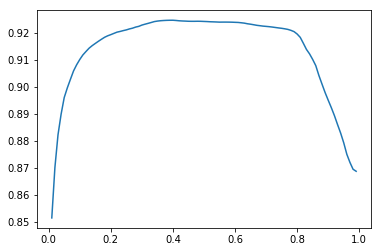

In [29]:
lst=[]
for t in np.arange(0.01,1,0.01):
    i=ypred>t
    lst.append( [t, np.mean(i==ytrue)])
lst=np.array(lst)
i=np.argmax(lst[:,1])
print lst[i]
plt.plot(lst[:,0],lst[:,1]);

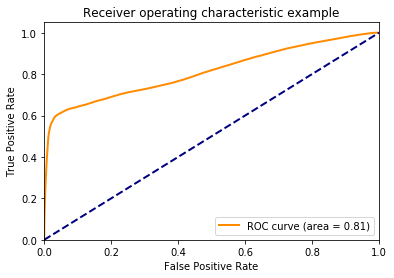

In [30]:
plt.figure()
lw = 2
plt.plot(fpr , tpr , color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [32]:
daily_test=daily_data[:,-128:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [36]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [37]:
predTest=np.round(predTest,5)
np.mean(predTest>0.8)

0.018208640383833231

In [38]:
predTest

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          9.99999975e-06,   9.99999975e-06,   9.99999975e-06],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          9.99999975e-06,   1.99999995e-05,   1.99999995e-05],
       [  1.33600002e-02,   1.13199996e-02,   1.24899996e-02, ...,
          7.55999982e-03,   8.01999960e-03,   9.44000017e-03],
       ..., 
       [  9.50779974e-01,   9.47709978e-01,   9.52669978e-01, ...,
          8.10869992e-01,   8.15169990e-01,   8.17770004e-01],
       [  9.50779974e-01,   9.47709978e-01,   9.52669978e-01, ...,
          8.10869992e-01,   8.15169990e-01,   8.17770004e-01],
       [  9.50779974e-01,   9.47709978e-01,   9.52669978e-01, ...,
          8.10869992e-01,   8.15169990e-01,   8.17770004e-01]], dtype=float32)

In [39]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [40]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['prob','name']

In [41]:
submission=submission[["name",'prob']]
submission.head()

name     prob
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  0.00000
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  0.00000
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01  0.01336
3  4minute_zh.wikipedia.org_all-access_spider_201...  0.00003
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  0.00034

In [42]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [43]:
keys_dict=keys["Id"].to_dict()

In [44]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [45]:
submission.isnull().sum().sum()

0L

In [46]:
submission.head()

name     prob            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  0.00000  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  0.00000  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01  0.01336  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  0.00003  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  0.00034  75bae1fb2637

In [47]:
submission[["Id","prob"]].to_csv("../submission/zeropred_lstm_60.csv.gz",
                                   index=None, float_format='%.5f', compression="gzip")